<a href="https://colab.research.google.com/github/ThanosApostolou/aics-pattern-recognition/blob/main/%CE%91%CE%BD%CF%84%CE%AF%CE%B3%CF%81%CE%B1%CF%86%CE%BF_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/ThanosApostolou/aics-pattern-recognition/blob/main/IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# INSTALL DEPENDENCIES
# Uncomment and run only once.
!pip install matplotlib numpy pandas scikit-learn scipy tensorflow pyclustering

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 22.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395118 sha256=6733b85c3ce023e07de9b700c6d0a4d647871257ffe2ad853b070dc80bab3a6c
  Stored in directory: /root/.cache/pip/wheels/e0/56/c2/abb6866a3fcd8a55862f1df8a18f57805c3a78fed9a9023cb9
Successfully built pyclustering


In [ ]:
# IMPORTS AND GLOBAL CONSTANTS

# Load the TensorBoard notebook extension
%load_ext tensorboard

import tensorflow as tf
import datetime, os
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import typing
import numpy.typing as np_typing

##MAIN PROGRAM VARIABLES##
##(0): dataset: np array of strings
##(1): dataframe: original dataset in its primal form
##(2): ratings_num_df: new dataframe storing the number of rated items per unique user
##(3): ratings_span_df: new dataframe storing the timespan in days for each user
##(4): minimum_ratings - maximum_ratings => ratings_df=> (i) final_df

# Constants
DATASET_FILE_PATH = "./Dataset.npy"
#Define the figures path
FIGURES_PATH = "figures"
os.makedirs(FIGURES_PATH, exist_ok=True)
# #Define the data folder path
DATAFOLDER_PATH = "datafiles"
os.makedirs(DATAFOLDER_PATH, exist_ok=True)

if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  from google.colab import drive
  drive.mount('/content/drive/')
  DATASET_FILE_PATH = "/content/drive/My Drive/Colab Notebooks/Dataset.npy"


Running on CoLab
Mounted at /content/drive/


In [ ]:
dataset: np.ndarray = np.load(DATASET_FILE_PATH)
# TODO delete this when we fix performance
dataset = dataset[:min(100000, dataset.size)]

In [ ]:
#Define the splitter lambda function in order to tokenize the initial string data.
splitter = lambda s: s.split(",")
#Apply the splitter lambda function on the string np array
dataset = np.array([splitter(x) for x in dataset])
#Set the pickle file for storing the initial dataframe
pickle_file = os.path.join(DATAFOLDER_PATH, "dataframe.pkl")
#Check the existence of the specified file.
if os.path.exists(pickle_file):
    #Load the pickle file
    dataframe = pd.read_pickle(pickle_file)
else:
    #Create the dataframe object.
    dataframe = pd.DataFrame(dataset, columns=['User','Movie','Rating','Date'])
    #Convert the string elements of the "Users" series into integers
    dataframe["User"] = dataframe["User"].apply(lambda s:np.int64(s.replace("ur","")))
    #Convert the string elements of the "Movies" series into integers
    dataframe["Movie"] = dataframe["Movie"].apply(lambda s:np.int64(s.replace("tt","")))
    #Convert the string elements of the "Ratings" series into integers
    dataframe["Rating"] = dataframe["Rating"].apply(lambda s:np.int64(s))
    #Convert the string element of "Dates" series into datetime Object
    dataframe["Date"] = pd.to_datetime(dataframe["Date"])
    dataframe.to_pickle(pickle_file)

In [ ]:
#Get the unique users in the dataset.
users = dataframe["User"].unique()
#Get the number of unique users
users_num = len(users)
#Get the unique movie items in the dataset.
movies = dataframe["Movie"].unique()
#Get the number of unique movies
movies_num = len(movies)
#Get the total number of existing ratings.
ratings_num = dataframe.shape[0]
#Report the number of unique Users and Movies in the dataset
print("INITIAL DATASET: {0} number of unique users and {1} of unique movies".format(users_num, movies_num))
#Report the total number of existing ratings in the dataset
print("INITIAL DATASET: {} total number of existing ratings".format(ratings_num))

INITIAL DATASET: 51655 number of unique users and 26570 of unique movies
INITIAL DATASET: 100000 total number of existing ratings


In [ ]:
#Define the pickle file that will store the time span per user dataframe
pickle_file = os.path.join(DATAFOLDER_PATH, "ratings_num_df.pkl")
#Check the existence of the previously defined pickle file
if os.path.exists(pickle_file):
    #Load the pickle file
    ratings_num_df = pd.read_pickle(pickle_file)
else:
    ratings_num_df = dataframe.groupby("User")["Rating"].count().sort_values(ascending=False).reset_index(name="ratings_num")
    #Save the previously created dataframe to pickle
    ratings_num_df.to_pickle(pickle_file)

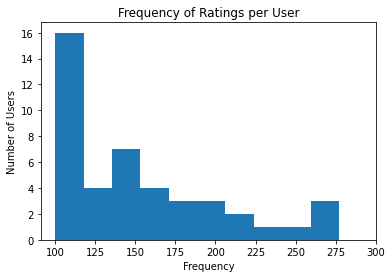

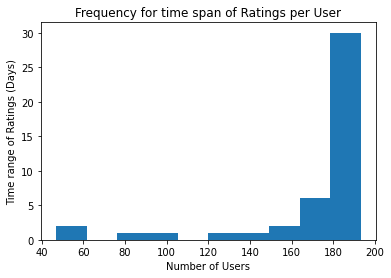

In [ ]:
#Set the pickle file that will store the time span per user dataframe
pickle_file = os.path.join(DATAFOLDER_PATH, "ratings_span_df.pkl")
if os.path.exists(pickle_file):
    ratings_span_df = pd.read_pickle(pickle_file)
else:
    ratings_span_df = dataframe.groupby("User")["Date"].apply(lambda date: max(date)-min(date)).sort_values(ascending=False).reset_index(name="ratings_span")
    ratings_span_df.to_pickle(pickle_file)
#Create a new ratings dataframe by joining the previously defined dataframe
ratings_df = ratings_num_df.join(ratings_span_df.set_index("User"),on="User")
ratings_df["ratings_span"]=ratings_df["ratings_span"].dt.days
#Set the threshold values for the minimum and maximum number of Ratings per user
minimum_ratings = 100
maximum_ratings = 300
#Discard all users that do not pertain to the previous range of ratings
reduced_ratings_df = ratings_df.loc[(ratings_df["ratings_num"] >= minimum_ratings) & (ratings_df["ratings_num"] <= maximum_ratings)]

#Generate the frequency histogram for the number of ratings per user
reduced_ratings_df["ratings_num"].plot(kind='hist', title='Frequency of Ratings per User', xticks=range(minimum_ratings, maximum_ratings+1, 25))
plt.xlabel('Frequency')
plt.ylabel('Number of Users')

plt.show()
#Generate the frequency histogram for the time span of ratings per user
reduced_ratings_df["ratings_span"].plot(kind='hist', title='Frequency for time span of Ratings per User')
plt.xlabel('Number of Users')
plt.ylabel('Time range of Ratings (Days)')

plt.show()



                                                                                    

In [ ]:
#Get the final dataframe by excluding all users whose ratings fall outside the prespecified range
final_df = dataframe.loc[dataframe["User"].isin(reduced_ratings_df["User"])].reset_index()
#Drop the links (indices) to the original table
final_df = final_df.drop("index", axis=1)
#Get the unique users and items in the final dataframe along with the final number of ratings
final_users = final_df["User"].unique()
final_movies = final_df["Movie"].unique()
final_users_num = len(final_users)
final_movies_num = len(final_movies)
final_ratings_num = len(final_df)

#Report the final number of unique users and movies in the dataset
print("REDUCED DATASET: {0} number of unique users and {1} number of unique movies".format(final_users_num, final_movies_num))
#Report the final number of existing ratings in the dataset
print("REDUCED DATASET: {} number of existing ratings in the dataset".format(final_ratings_num))

REDUCED DATASET: 44 number of unique users and 5042 number of unique movies
REDUCED DATASET: 6735 number of existing ratings in the dataset


In [ ]:
#We need to reset the users and items IDs in order to be able to construct a network of users and Movies. 
#Users and Movies IDs should be consecutive in the [1..final_users_num] and [1...final_movies_num]
#Initially, we need to acquire the sorted versions of the user and movies
sorted_final_users = np.sort(final_users)
sorted_final_movies = np.sort(final_movies)
#Generate the dictionary of final users as a mapping of the following 
#sorted_final_users --> [0...final_users_num-1]
final_users_dict = dict(zip(sorted_final_users,list(range(0,final_users_num))))
#Generate the dictionary of final items as a mapping of the following
final_movies_dict = dict(zip(sorted_final_movies,list(range(0,final_movies_num))))
#Apply the previously defined dictionary-based maps on the users and movies columns of the final dataframe
final_df["User"] = final_df["User"].map(final_users_dict)
final_df["Movie"] = final_df["Movie"].map(final_movies_dict)
#Get a grouped version of the original dataframe based on the unique final users
users_group_df = final_df.groupby("User")
#Initialize the adjacency matrix which stores the connection status for pair of users in the recommendation network
W = np.zeros((final_users_num, final_users_num))
#Iinitialize the matrix storing the number of commonly rated items for a pair of users
CommonRatings = np.zeros((final_users_num, final_users_num))
#Initialize the matrix of common ratings
#Matrix W will be of size [final_users_num x final_users_num],
#Let U = {u1, u2,...,un} be the final set of users and I = {i1,i2,...,im}
#final set of movies. By considering the function Fi: U -> P(I) where
#P(I) is the powerset of I, Fi(u) returns the subset of items that has been rated by user u. 
#In this context, the edge weight between any given pair of users (u,v) will be computed as:
#
#          |Intersection(Fi(u)),Fi(v))|
#W(u,v) =  -----------------------------
#               |Union(Fi(u),Fi(v))|
#
#
#In order to speed up the construction of the adjacency matrix for the ratings network, 
#construct a dictionary object that will store a set of rated items for each unique user.
user_items_dict = {}
# for user in final_users:
    #print(user)
    # user_index = final_users_dict[user]
    # user_movies = set(users_group_df.get_group(user_index)["Movie"])
    # user_items_dict[user_index] = user_movies
                                                 
# Initialize the dictionary for storing the set of rated items for each user
user_items_dict = {}
# print(final_users_dict)
# print(sorted_final_users)
# print(final_users_dict)
# For each unique user, find the set of movies that they rated
for user in final_users:
    if user in final_users_dict:
        user_index = final_users_dict[user]
        user_movies = set(users_group_df.get_group(user_index)["Movie"])
        user_items_dict[user_index] = user_movies 

In [ ]:
user_ids = list(user_items_dict.keys())
user_ids.sort()
#Generate the sorted version of the dictionary
user_items_dict = {user_index:user_items_dict[user_index] for user_index in user_ids}
#Set the pickle file that will store the graph adjacency matrix W.
pickle_file_weights = os.path.join(DATAFOLDER_PATH, "w")
pickle_file_common_ratings = os.path.join(DATAFOLDER_PATH, "common_ratings")
#Check the existence of the previously defined pickle file
if os.path.exists(pickle_file_weights) & os.path.exists(pickle_file_common_ratings):
    #Load the pickle file
    W = np.load(pickle_file_weights)
    CommonRatings = np.load(pickle_file_common_ratings)
else:
    for source_user in user_items_dict.keys():
        for target_user in user_items_dict.keys():
            intersection_items = user_items_dict[source_user].intersection(user_items_dict[target_user])
            union_items = user_items_dict[source_user].union(user_items_dict[target_user])
            W[source_user, target_user] = len(intersection_items)/len(union_items)
            CommonRatings[source_user, target_user] = len(intersection_items)
    np.save(pickle_file_weights,W)
    np.save(pickle_file_common_ratings,CommonRatings)

In [ ]:
W

array([[1.        , 0.        , 0.00829876, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.0042735 , 0.01463415,
        0.00315457],
       [0.00829876, 0.        , 1.        , ..., 0.        , 0.01470588,
        0.        ],
       ...,
       [0.        , 0.0042735 , 0.        , ..., 1.        , 0.        ,
        0.01179941],
       [0.        , 0.01463415, 0.01470588, ..., 0.        , 1.        ,
        0.0031746 ],
       [0.        , 0.00315457, 0.        , ..., 0.01179941, 0.0031746 ,
        1.        ]])

In [ ]:
CommonRatings

array([[139.,   0.,   2., ...,   0.,   0.,   0.],
       [  0., 105.,   0., ...,   1.,   3.,   1.],
       [  2.,   0., 104., ...,   0.,   3.,   0.],
       ...,
       [  0.,   1.,   0., ..., 130.,   0.,   4.],
       [  0.,   3.,   3., ...,   0., 103.,   1.],
       [  0.,   1.,   0., ...,   4.,   1., 213.]])

In [ ]:
final_df

,User,Movie,Rating,Date
0,40,3324,3,2005-01-16
1,40,2583,8,2005-01-16
2,40,3431,8,2005-01-16
3,18,1627,7,2005-01-16
4,40,3748,9,2005-01-16
...,...,...,...,...
6730,25,4784,8,2005-07-26
6731,43,414,8,2005-07-26
6732,18,4006,1,2005-07-26
6733,0,341,8,2005-07-26


#Δημιουργούμε έναν πίνακα χρηστών - ταινιών 
(οι χρήστες βρίσκονται στις γραμμές και οι ταινίες στις στήλες του πίνακα)
όπου τα στοιχεία του πίνακα είναι από 1 - 10. Εάν ο χρήστης δεν έχει αξιολογήσει την ταινία,
η αξιολόγηση που θα ανατεθεί είναι 0.

In [ ]:
# Create a pivot table of user-movie ratings
ratings_matrix = final_df.pivot_table(index='User', columns='Movie', values='Rating')
ratings_matrix = ratings_matrix.fillna(0)

In [ ]:
ratings_matrix

Movie,0,1,2,3,4,5,6,7,8,9,...,5032,5033,5034,5035,5036,5037,5038,5039,5040,5041
User,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,10.0,1.0,0.0,1.0,6.0,5.0,4.0,10.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.samples.definitions import FCPS_SAMPLES
from pyclustering.utils import read_sample
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric

Θέλουμε να δημιουργήσουμε τον πίνακα βαρών "λ" των χρηστών. Τον πίνακα αξιολογήσεων δηλαδή όπου η τιμή της αξιολόγησης είναι 1 εάν η ταινία έχει αξιολογηθεί από τον χρήστη ή 0 εάν δεν έχει αξιολογηθεί

In [ ]:
# Threshold
threshold = 1

# Transform to binary
binary_matrix = np.where(ratings_matrix >= threshold, 1, 0)

In [ ]:
binary_matrix

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# Convert the matrix to a numpy array
matrix_array = ratings_matrix.to_numpy()

# Create a dictionary that maps each row of the matrix to its index
# matrix_dict = {tuple(row): i for i, row in enumerate(matrix_array)}

# ***Αλγόριθμοι Ομαδοποίησης Δεδομένων***

**Χρήση της Weighted Euclidean Distance**

In [ ]:
from scipy.spatial.distance import pdist, cdist
import numpy as np

from scipy.sparse import csr_matrix

def pairwise_weighted_euclidean_distance(X, weights):
    # Find the indices of the rated movies for each pair of users
    rated_movies = (weights_sparse.T @ weights_sparse) > 0

    # Select only the rated movies for each pair of users
    X_rated = X_sparse[:, rated_movies]
    
    # Calculate the pairwise weighted Euclidean distance between 
    #users who have rated the same movie
    return cdist(X, metric='euclidean')

def kmeans_pairwise_weighted_euclidean(X, weights, k, max_iters=2):

    n, m = X.shape
    centroids = X[np.random.choice(n, k, replace=False)]
    distances = pairwise_weighted_euclidean_distance(X, weights)
    for i in range(max_iters):
        # Assign points to clusters
        cluster_assignments = np.argmin(distances, axis=1)

        # Recalculate cluster centroids
        for j in range(k):
            cluster_points = X[cluster_assignments == j]
            if len(cluster_points) > 0:
                centroids[j] = np.average(cluster_points, axis=0)

        # Update distances to centroids
        distances = pairwise_weighted_euclidean_distance(X, weights)

    return cluster_assignments, centroids


# Clustering users using K-means
 We want to start by creating the symmetric D matrix which contains the pairwise weighted Euclidean distance for every pair of users.
 We calculate the distance between each user using 
*   dist_{u,v}=\sum_{k=1}^{n}\sqrt{|R_{u}(k) - R_{v}(k)|λ_{u}(k)λ_{v}(k)}




In [ ]:
# Calculate the pairwise weighted Euclidean distance matrix

def create_euclidean_distance_matrix_cached(ratings_matrix: pd.DataFrame, binary_matrix: np_typing.NDArray) -> np_typing.NDArray[np.float64]:
    #Set the npy file that will store the Euclidean distance matrix
    npy_file = os.path.join(DATAFOLDER_PATH, "euclidean_distance_matrix.npy")
    if os.path.exists(npy_file):
        Dist_euclidean: np_typing.NDArray[np.float64] = np.load(npy_file, allow_pickle=True)
        return Dist_euclidean
    else:
        n = ratings_matrix.shape[0]
        Dist_euclidean = np.zeros((n, n))
        for i in range(n):
            for j in range(i, n):
                d = np.sqrt(np.sum(binary_matrix[i,:]*binary_matrix[j,:] * (ratings_matrix.iloc[i,:] - ratings_matrix.iloc[j,:])**2))
                Dist_euclidean[i,j] = d
                Dist_euclidean[j,i] = d
        np.save(npy_file, Dist_euclidean, allow_pickle=True, fix_imports=True)
        return Dist_euclidean


Dist_euclidean = create_euclidean_distance_matrix_cached(ratings_matrix, binary_matrix)
Dist_euclidean

array([[0.        , 0.        , 4.47213595, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 3.        , 2.23606798,
        0.        ],
       [4.47213595, 0.        , 0.        , ..., 0.        , 3.        ,
        0.        ],
       ...,
       [0.        , 3.        , 0.        , ..., 0.        , 0.        ,
        3.16227766],
       [0.        , 2.23606798, 3.        , ..., 0.        , 0.        ,
        2.        ],
       [0.        , 0.        , 0.        , ..., 3.16227766, 2.        ,
        0.        ]])

In [ ]:
df_euclidean = pd.DataFrame(Dist_euclidean)
df_euclidean

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,0.000000,0.000000,4.472136,0.000000,0.000000,7.810250,0.000000,4.242641,0.000000,3.162278,...,1.000000,0.000000,7.141428,9.110434,3.464102,1.000000,6.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,3.162278,...,2.000000,0.000000,4.123106,0.000000,0.000000,1.000000,5.567764,3.000000,2.236068,0.000000
2,4.472136,0.000000,0.000000,0.000000,2.000000,7.615773,1.732051,7.937254,0.000000,4.358899,...,0.000000,6.855655,9.165151,6.244998,13.453624,5.000000,13.190906,0.000000,3.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.582576,0.000000,...,0.000000,0.000000,3.464102,0.000000,0.000000,2.000000,0.000000,2.000000,2.645751,2.236068
4,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,3.741657,0.000000,0.000000,...,1.414214,1.000000,0.000000,1.414214,4.472136,0.000000,0.000000,0.000000,0.000000,3.162278
5,7.810250,0.000000,7.615773,0.000000,0.000000,0.000000,4.582576,7.071068,2.828427,6.633250,...,2.000000,9.055385,4.358899,5.477226,10.723805,6.000000,9.380832,0.000000,5.196152,0.000000
6,0.000000,1.000000,1.732051,0.000000,1.000000,4.582576,0.000000,6.928203,6.082763,5.656854,...,0.000000,6.324555,3.162278,6.403124,5.477226,3.872983,6.633250,2.000000,5.000000,3.464102
7,4.242641,1.000000,7.937254,0.000000,3.741657,7.071068,6.928203,0.000000,9.899495,5.477226,...,3.605551,3.316625,1.414214,9.899495,13.928388,1.000000,5.291503,0.000000,2.236068,0.000000
8,0.000000,0.000000,0.000000,4.582576,0.000000,2.828427,6.082763,9.899495,0.000000,10.488088,...,3.605551,4.123106,8.485281,7.141428,12.288206,3.605551,1.000000,0.000000,4.472136,4.690416
9,3.162278,3.162278,4.358899,0.000000,0.000000,6.633250,5.656854,5.477226,10.488088,0.000000,...,5.000000,7.549834,12.041595,2.449490,5.196152,9.643651,11.575837,5.000000,3.162278,2.000000


Στον πίνακα αποστάσεων που έχουμε δημιουργήσει, θα τρέξουμε τον αλγόριθμο k-means ώστε να αποτιμήσουμε την ομοιότητα των χρηστών χρησιμοποιώντας τις μεταξύ τους αποστάσεις.

In [ ]:
from sklearn.cluster import KMeans
# Cluster the users using K-means
kmeans = KMeans(n_clusters=5).fit(Dist_euclidean)

# Get the cluster labels
labels_euclidean = kmeans.labels_

# Print the labels
print(labels_euclidean)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[4 1 0 1 1 0 0 0 0 0 4 1 1 4 1 2 0 1 3 0 1 2 1 0 4 0 2 3 1 3 2 1 4 4 1 0 3
 0 2 4 3 1 4 1]


Cluster the users, by using a custom 
dist = 1 - np.abs(np.sum(R_u*R_v*weights_u*weights_l)/(np.sqrt(R^2_u*weights_u*weights_l)*np.sqrt(R^2_v*weights_u*weights_l)

---



In [ ]:
# Calculate the pairwise weighted Cosine distance matrix

def create_cosine_distance_matrix_cached(ratings_matrix: pd.DataFrame, binary_matrix: np_typing.NDArray) -> np_typing.NDArray[np.float64]:
    #Set the npy file that will store the Euclidean distance matrix
    npy_file = os.path.join(DATAFOLDER_PATH, "cosine_distance_matrix.npy")
    if os.path.exists(npy_file):
        Dist_cosine: np_typing.NDArray[np.float64] = np.load(npy_file, allow_pickle=True)
        return Dist_cosine
    else:
        n = ratings_matrix.shape[0]
        Dist_cosine = np.zeros((n, n))
        for i in range(n):
            for j in range(i, n):
                d = 1 - np.abs(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[i,:] * ratings_matrix.loc[j,:]) / (np.sqrt(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[i,:])* np.sqrt(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[j,:])))))
                Dist_cosine[i,j] = d
                Dist_cosine[j,i] = d
        np.save(npy_file, Dist_cosine, allow_pickle=True, fix_imports=True)
        return Dist_cosine


Dist_cosine = create_cosine_distance_matrix_cached(ratings_matrix, binary_matrix)
Dist_cosine

<ipython-input-25-71bab809ab24>:14: RuntimeWarning: invalid value encountered in double_scalars
  d = 1 - np.abs(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[i,:] * ratings_matrix.loc[j,:]) / (np.sqrt(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[i,:])* np.sqrt(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[j,:])))))


array([[-36.63435099,          nan,  -3.85491772, ...,          nan,
                 nan,          nan],
       [         nan, -37.6101432 ,          nan, ..., -13.87815298,
        -13.19433529, -12.45434264],
       [ -3.85491772,          nan, -27.58734382, ...,          nan,
        -12.87853171,          nan],
       ...,
       [         nan, -13.87815298,          nan, ..., -42.32831524,
                 nan, -17.26795661],
       [         nan, -13.19433529, -12.87853171, ...,          nan,
        -31.7969314 , -10.65180252],
       [         nan, -12.45434264,          nan, ..., -17.26795661,
        -10.65180252, -49.70987085]])

In [ ]:
df_cosine = pd.DataFrame(Dist_cosine)
df_cosine = df_cosine.replace(np.nan, 0)
df_cosine

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,-36.634351,0.000000,-3.854918,0.000000,0.000000,-10.560414,0.000000,-7.335135,-10.386036,-9.357398,...,-11.585385,0.000000,-10.836397,-6.036780,-7.357289,-11.585385,-3.303517,0.000000,0.000000,0.000000
1,0.000000,-37.610143,0.000000,0.000000,0.000000,0.000000,-15.870240,-7.190363,-10.386036,-15.348895,...,-10.651803,0.000000,-14.619538,0.000000,0.000000,-7.190363,-17.066272,-13.878153,-13.194335,-12.454343
2,-3.854918,0.000000,-27.587344,0.000000,-12.747727,-16.843199,-13.137432,-16.688013,-12.454343,-12.586292,...,0.000000,-17.384357,-12.667873,-14.763239,-12.826284,-7.239069,-22.438579,0.000000,-12.878532,0.000000
3,0.000000,0.000000,0.000000,-44.493558,0.000000,-10.386036,0.000000,0.000000,-21.139400,0.000000,...,-15.000000,0.000000,-19.516787,0.000000,0.000000,-13.475248,-16.319339,-14.682205,-15.066719,-21.090722
4,0.000000,0.000000,-12.747727,0.000000,-36.499119,0.000000,-20.250166,-21.594243,0.000000,0.000000,...,-13.851356,-13.270485,0.000000,-15.970563,-12.677042,0.000000,0.000000,0.000000,0.000000,-13.583537
5,-10.560414,0.000000,-16.843199,-10.386036,0.000000,-45.239808,-18.538586,-16.666918,-20.856051,-13.692370,...,-11.910551,-19.432702,-20.541693,-12.843576,-8.523592,-18.312761,-18.868520,0.000000,-13.883960,0.000000
6,0.000000,-15.870240,-13.137432,0.000000,-20.250166,-18.538586,-45.554151,-20.436463,-16.416806,-8.810959,...,-10.386036,-21.300853,-16.234958,-12.978260,-13.757979,-19.220466,-15.403313,-10.651803,-13.051825,-18.796928
7,-7.335135,-7.190363,-16.688013,0.000000,-21.594243,-16.666918,-20.436463,-32.814240,-15.396635,-9.198039,...,-7.529134,-20.030893,-15.042951,-17.818442,-16.204043,-11.481399,-19.379954,0.000000,-10.446756,0.000000
8,-10.386036,-10.386036,-12.454343,-21.139400,0.000000,-20.856051,-16.416806,-15.396635,-41.287482,-9.889321,...,-12.185142,-9.208414,-4.117773,-11.159200,-7.046968,-9.856436,-13.270485,0.000000,-12.677042,-21.064037
9,-9.357398,-15.348895,-12.586292,0.000000,0.000000,-13.692370,-8.810959,-9.198039,-9.889321,-35.437632,...,-9.958775,-14.185164,-19.082292,-7.220343,-14.744471,-15.208087,-21.313241,-11.574334,-15.021851,-8.622957


Στον πίνακα αποστάσεων που έχουμε δημιουργήσει, θα τρέξουμε τον αλγόριθμο k-means ώστε να αποτιμήσουμε την ομοιότητα των χρηστών χρησιμοποιώντας τις μεταξύ τους αποστάσεις.

In [ ]:
# Cluster the users using K-means
kmeans = KMeans(n_clusters=5).fit(df_cosine)

# Get the cluster labels
labels_cosine = kmeans.labels_

# Print the labels
print(labels_cosine)


[0 3 1 4 1 3 1 1 3 3 1 4 0 1 0 2 2 3 3 2 4 3 0 3 3 2 2 2 4 1 2 1 1 3 0 2 2
 1 1 3 2 4 3 4]


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Elbow Method
Χρησιμοποιούμε την elbow method ώστε να επιλέξουμε τον βέλτιστο αριθμό clusters στον οποίο θα διαχωριστούν τα δεδομένα χρησιμοποιώντας τον k-means

In [ ]:
def elbow_method(df: pd.DataFrame, max_iter: int):
  distortions = []
  K = range(1,max_iter)
  for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df)
    distortions.append(kmeanModel.inertia_)
  plt.figure(figsize=(16,8))
  plt.plot(K, distortions, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Distortion')
  plt.title('The Elbow Method showing the optimal k')
  plt.show()


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

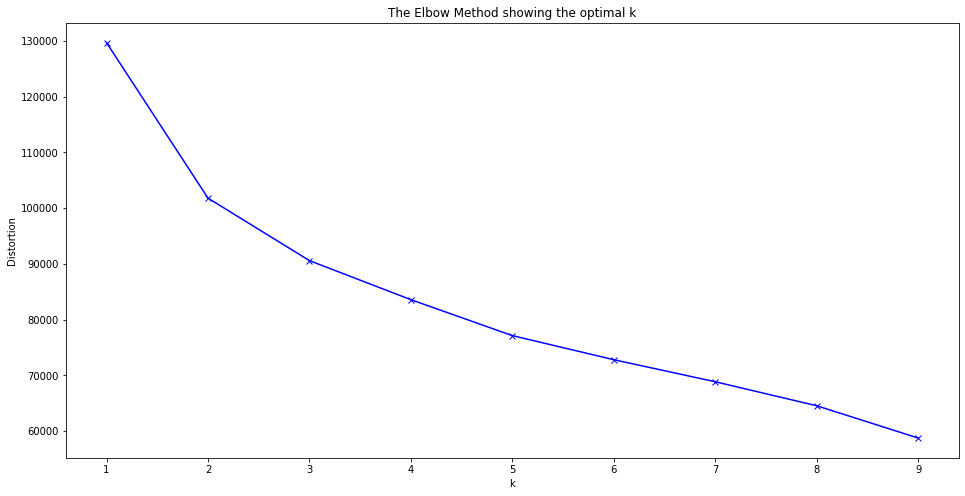

In [ ]:
#Using the elbow method on Cosine distance
elbow_method(df_cosine, 10)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

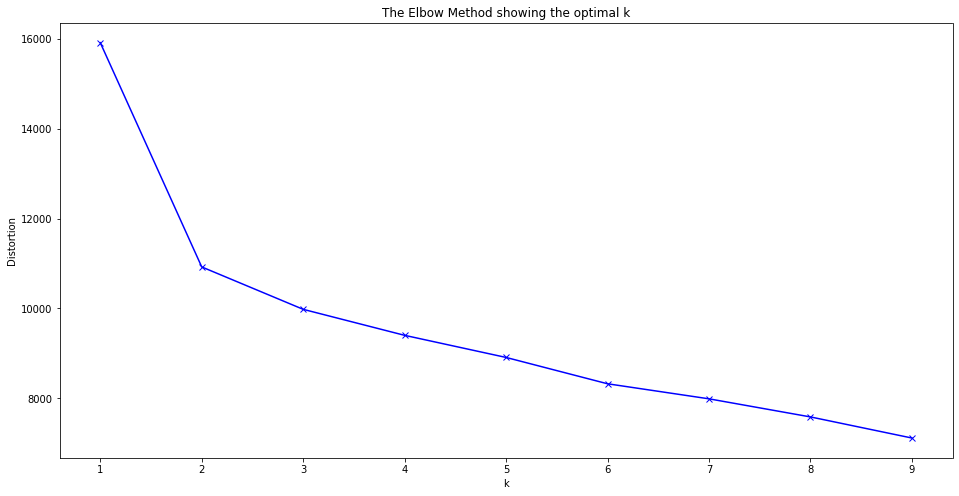

In [ ]:
#Using the elbow method on Euclidean distance
elbow_method(Dist_euclidean, 10)

First, we have to modify our df in order to keep the first n users and assign our labels to them

In [ ]:
# ratings_matrix = ratings_matrix.head(100)
ratings_matrix

Movie,0,1,2,3,4,5,6,7,8,9,...,5032,5033,5034,5035,5036,5037,5038,5039,5040,5041
User,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,10.0,1.0,0.0,1.0,6.0,5.0,4.0,10.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, we'll use the PCA method in order to reduce the dimensionality of our matrix and plot our clusters

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# instantiate StandardScaler and PCA with 2 components for 2D scatter plot
scaler = StandardScaler()
pca = PCA(n_components=2)

# fit and transform the ratings matrix
ratings_pca = pca.fit_transform(ratings_matrix)

# print the explained variance ratio for each component
print(pca.explained_variance_ratio_)

[0.07182318 0.04794243]


In [ ]:
# create a new dataframe with the PCA components and user index
df_pca = pd.DataFrame(ratings_pca, index=range(0, ratings_matrix.shape[0]))
df_pca['Cluster'] = labels_euclidean
df_pca

,0,1,Cluster
0,-2.311120,-5.091169,4
1,-4.547523,-1.887186,1
2,-2.419967,3.771057,0
3,-7.721714,-7.750596,1
4,-4.500850,-5.503332,1
5,-3.105265,-3.327732,0
6,-3.340097,-3.356853,0
7,0.711160,-1.007224,0
8,-5.245998,-7.399832,0
9,-3.583830,0.377762,0


In [ ]:
#Create a function to transform the DF with PCA to 2 coordinates and create a scatter plot

def plot_pca_cluster(ratings_matrix, n_clusters):
    # instantiate StandardScaler and PCA with 2 components for 2D scatter plot
    scaler = StandardScaler()
    pca = PCA(n_components=2)

    # fit and transform the ratings matrix
    ratings_pca = pca.fit_transform(ratings_matrix)

    # apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(ratings_matrix)

    # create a new dataframe with the PCA components and cluster labels
    df_pca = pd.DataFrame(ratings_pca, index=range(0, ratings_matrix.shape[0]), columns=['Component 1', 'Component 2'])
    df_pca['Cluster'] = labels

    # create a scatter plot of the PCA components with color-coded clusters
    fig, ax = plt.subplots()

    for label, color in zip(df_pca['Cluster'].unique(), ['blue', 'red', 'green', 'orange', 'purple']):
        group = df_pca.groupby('Cluster').get_group(label)
        ax.scatter(group['Component 1'], group['Component 2'], c=color, label=f'Cluster {label}')

    # set the axis labels and title
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_title('PCA Transformed User-Movie Ratings')

    # add a legend
    ax.legend()

    # show the plot
    plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


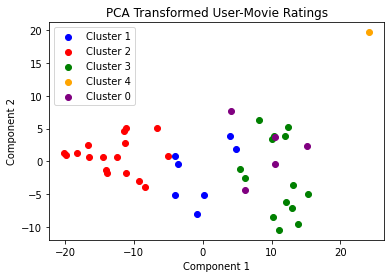

In [ ]:
plot_pca_cluster(df_euclidean, 5)

Να σχολιάσετε την αποτελεσματικότητα των συγκεκριμένων μετρικών στην αποτίμηση της ομοιότητας μεταξύ ενός ζεύγους διανυσμάτων προτιμήσεων χρηστών R_u και R_v.

Για την μετρική της ευκλείδιας απόστασης: 


*   Η ομοιότητα των χρηστών είναι **αντιστρόφως ανάλογη** της απόστασης μεταξύ τους.
*   Για να έχουμε αποτέλεσμα, θα πρέπει να υπάρχει **επικάλυψη μεταξύ των χρηστών.** Πρέπει δηλαδή να έχουν αξιολογήσει κοινές ταινίες.
*   Ο υπολογισμός του k-means γίνεται πολύ πιο υπολογιστικά εντατικός λόγω των εκτεταμένων πολλαπλασιασμών πινάκων που εκτελείται.


---


Για την μετρική του συνημιτόνου:


1.   Για να έχουμε αποτέλεσμα, θα πρέπει να υπάρχει **επικάλυψη μεταξύ των χρηστών.** Πρέπει δηλαδή να έχουν αξιολογήσει κοινές ταινίες.
2.   Ο υπολογισμός του k-means γίνεται πολύ πιο υπολογιστικά εντατικός λόγω των εκτεταμένων πολλαπλασιασμών πινάκων που εκτελείται.
3.   Η ομοιότητα των χρηστών μπορεί να υπολογιστεί στην περίπτωση που είναι η γωνία μεταξύ των διανυσμάτων τους από 0 - 90 ως ομοιότητα ενώ από 90 - 180 μπορούμε να εκφράσουμε την αντίθεση των χρηστών. Οπότε σε κάθε περίπτωση η μετρική μας βοηθά να ομαδοποιήσουμε τους χρήστες.





##JACCARD DISTANCE
Η απόσταση Jaccard απομετρά τη **διαφορετικότητα** μεταξύ δύο συνόλων (στην περίπτωσή μας δύο χρηστών). 



*   Στην περίπτωση που η τομή των δύο χρηστών γίνει μηδέν (δεν υπάρχουν δηλαδή κοινά αξιολογήσιμες ταινίες) η διαφορετικότητα των χρηστών παίρνει τη μέγιστη τιμή της, 1
*   Η διαφορετικότητα των χρηστών θα γίνει **ελάχιστη** όταν η *τομή* των δύο χρηστών είναι ίση με την *ένωσή* τους, όταν δηλαδή τα δύο σύνολα γίνουν *ίσα*
*   Μπορεί να χρησιμοποιηθεί για τη σύγκριση της ομοιότητας οποιουδήποτε είδους δεδομένων, συμπεριλαμβανομένων δεδομένων χρονοσειρών, φωτογραφιών, κειμένου και εικόνων.


---


Κάποια από τα μειονεκτήματα της ανωτέρω μετρικής είναι τα ακόλουθα:


---




*   **Απουσία "βαρών"**: Η απόσταση Jaccard εξετάζει μόνο την παρουσία ή την απουσία αξιολογήσεων για κάθε χρήστη και δεν λαμβάνει υπόψη τις πραγματικές τιμές αξιολόγησης. Μπορεί δηλαδή η *διαφορετικότητα*, η τιμή δηλαδή που θα προκύψει από την απόσταση Jaccard δύο χρηστών να είναι ελάχιστη, εάν έχουν αξιολογήσει τις ίδιες ταινίες ακόμα και αν ο ένας τις έχει αξιολογήσει με 5 και ο άλλος με 1.
*   **Αραιότητα αξιολογήσεων**: Για παράδειγμα, εάν δύο χρήστες έχουν αξιολογήσει μόνο έναν μικρό αριθμό ταινιών, είναι πιθανό να μην έχουν αξιολογήσει καμία από τις ίδιες ταινίες, άρα η τομή τους θα είναι μηδέν, με αποτέλεσμα η *διαφορετικότητά* τους να είναι μέγιστη, ακόμη και αν οι προτιμήσεις τους για τις ταινίες είναι στην πραγματικότητα αρκετά παρόμοιες. 




In [ ]:
jaccard_dist = 1 - W
print(jaccard_dist)
jaccard_df = pd.DataFrame(jaccard_dist)
jaccard_df

def kmeans_clustering(jaccard_dist, k):
    # Initialize k-means object
    kmeans = KMeans(n_clusters=k)

    # Fit the k-means object to the Jaccard distance matrix
    kmeans.fit(jaccard_dist)

    return kmeans.labels_

jaccard_labels = kmeans_clustering(jaccard_dist, 5)
print(jaccard_labels)

[[0.         1.         0.99170124 ... 1.         1.         1.        ]
 [1.         0.         1.         ... 0.9957265  0.98536585 0.99684543]
 [0.99170124 1.         0.         ... 1.         0.98529412 1.        ]
 ...
 [1.         0.9957265  1.         ... 0.         1.         0.98820059]
 [1.         0.98536585 0.98529412 ... 1.         0.         0.9968254 ]
 [1.         0.99684543 1.         ... 0.98820059 0.9968254  0.        ]]


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[2 2 0 4 1 3 1 1 1 2 1 0 3 1 3 1 1 3 3 0 3 2 2 3 0 3 0 2 4 1 0 1 0 1 3 0 0
 1 1 3 0 4 0 4]


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


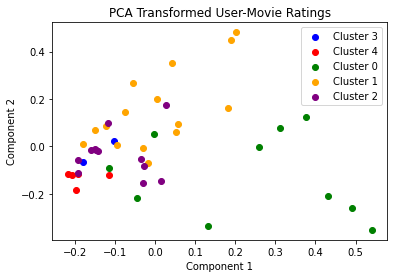

In [ ]:
plot_pca_cluster(jaccard_dist, 5)

# Neural Network 

### Pre - processing 

We will first start by seperating our Users according to the Cluster they've been assigned to, using the Jaccard distance on the K-Means algorithm.

We do this by creating a df containing the ratings of each user and the Cluster it belongs to.

In [ ]:
ratings_matrix_clustered = ratings_matrix

ratings_matrix_clustered['Cluster'] = jaccard_labels

ratings_matrix_clustered

Movie,0,1,2,3,4,5,6,7,8,9,...,5033,5034,5035,5036,5037,5038,5039,5040,5041,Cluster
User,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,10.0,1.0,0.0,1.0,6.0,5.0,4.0,10.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
6,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
#We sort the Labels of the Clusters from 0 to 4
clusters = sorted(ratings_matrix_clustered.Cluster.unique())

#We save each Cluster in an array where each position is for the same Cluster
clustered_DFs = []
for cluster in clusters:
    groupby_result = ratings_matrix_clustered.groupby('Cluster').get_group(cluster)
    clustered_DFs.append(groupby_result.to_numpy())
clustered_DFs[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
from sklearn.neighbors import NearestNeighbors

# define the custom distance metric based on Jaccard similarity score
def custom_distance(u, v):
    intersection = len(set(u).intersection(set(v)))
    union = len(set(u).union(set(v)))
    similarity = intersection / union
    return 1 - similarity

# instantiate the NearestNeighbors model with the custom distance metric
k = 5 # set the value of k
model = NearestNeighbors(n_neighbors=k, algorithm='brute', metric=custom_distance)

ratings = clustered_DFs[1]
# fit the model on the ratings matrix
model.fit(ratings)

# find the k-nearest neighbors for each user
k_nearest_neighbors = {}
for i in range(ratings.shape[0]):
    _, indices = model.kneighbors([ratings[i]], n_neighbors=k+1) # get indices of k+1 most similar users (including the user itself)
    # if we want to get the distance for each pair of users
    # neighbors = [(index, custom_distance(ratings[i], ratings[index])) for index in indices[0] if index != i] 
    neighbors = [index for index in indices[0] if index != i]
 # exclude the user itself
    k_nearest_neighbors[i] = neighbors

# We save our k_nearest_neighbors as a dict where for each user, we get the 
# most similar of their users. This will allow us to 
# Create a NN where the INPUT: will be the ratings of similar users
# and OUTPUT: the rating of the user we currently have.


In [ ]:
k_nearest_neighbors

{0: [4, 5, 7, 2, 9],
 1: [5, 7, 0, 4, 2],
 2: [4, 5, 7, 0, 9],
 3: [9, 6, 8, 5, 7],
 4: [5, 7, 0, 2, 9],
 5: [4, 7, 0, 2, 9],
 6: [9, 5, 7, 0, 4],
 7: [4, 5, 0, 2, 9],
 8: [3, 9, 6, 1, 10],
 9: [6, 5, 7, 0, 4],
 10: [9, 6, 1, 8, 7]}

#Creating the NN

In [ ]:
import tensorflow as tf
import numpy as np



# collect the ratings of the similar users and the target user
similar_user_ratings = []
target_user_ratings = []
ratings = ratings / 5
for i, neighbors in k_nearest_neighbors.items():
    similar_ratings = ratings[neighbors]
    target_ratings = ratings[i]
    similar_user_ratings.append(similar_ratings)
    target_user_ratings.append(target_ratings)

# convert the lists of ratings to numpy arrays
similar_user_ratings = np.array(similar_user_ratings)
target_user_ratings = np.array(target_user_ratings)

# create a neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(k, 5043)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5043)
])

# compile the model with an appropriate optimizer and loss function
model.compile(optimizer='adam', loss='mse')
# train the model using the nearest neighbors' ratings as input and the user's rating as output
for user_id in range(ratings.shape[0]):
    neighbors_ratings = [ratings[neighbor] for neighbor in k_nearest_neighbors[user_id] if neighbor != user_id]
    user_rating = ratings[user_id]
    X = np.array([neighbors_ratings])
    print(X.shape)
    y = np.array([user_rating])
    model.fit(X, y, epochs=10, batch_size=32)

Epoch 1/10
1/1 [==============================] - 1s 831ms/step - loss: 0.0011
Epoch 2/10
1/1 [==============================] - 0s 34ms/step - loss: 0.0010
Epoch 3/10
1/1 [==============================] - 0s 34ms/step - loss: 9.9229e-04
Epoch 4/10
1/1 [==============================] - 0s 34ms/step - loss: 9.7860e-04
Epoch 5/10
1/1 [==============================] - 0s 40ms/step - loss: 9.6578e-04
Epoch 6/10
1/1 [==============================] - 0s 31ms/step - loss: 9.5150e-04
Epoch 7/10
1/1 [==============================] - 0s 32ms/step - loss: 9.3517e-04
Epoch 8/10
1/1 [==============================] - 0s 29ms/step - loss: 9.1646e-04
Epoch 9/10
1/1 [==============================] - 0s 32ms/step - loss: 8.9448e-04
Epoch 10/10
1/1 [==============================] - 0s 31ms/step - loss: 8.6970e-04
Epoch 1/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0023
Epoch 2/10
1/1 [==============================] - 0s 32ms/step - loss: 0.0023
Epoch 3/10
1/1 [==============